In [1]:
import numpy as np
import pandas as pd
import support_vector_fuzzifier as svf
import math
from possibilearn import GaussianKernel

In [2]:
def get_eta(values, kernel, us, gamma):
    
    '''
    calculates the parameter eta with (27) in Probabilistic C-Means
    '''
    
    b = 1.0/sum(us)
    
    cp = zip(values,us)
    gram_term = b * b * sum([ u1*u2*kernel.compute(x1,x2) for (x1,u1) in cp for x2,u2 in cp])
    
    kernel_term =[]
    kernel_term2 = []
    for i in range(len(us)):
        kernel_term.append(kernel.compute(values[i], values[i]))
        kernel_term2.append( 2.0*b* sum( [us[i]*kernel.compute(values[i],x) for x in values] ))
                            
    return gamma * b * sum([u*(k - k2 + gram_term) for (u,k,k2) in zip (us, kernel_term, kernel_term2)])
        
                            
def update_us(values, kernel, us, eta):
    
    '''
    return the updated u with (26) in Probabilistic C-Means
    '''
    
    b = 1.0/sum(us)
    
    cp = zip(values,us)
    gram_term = b * b * sum([u1*u2*kernel.compute(x1,x2) for (x1,u1) in cp for x2,u2 in cp])
    
    kernel_term =[]
    kernel_term2 = []
    for i in range(len(us)):
        kernel_term.append(kernel.compute(values[i], values[i]))
        kernel_term2.append( 2.0*b* sum( [us[i]*kernel.compute(values[i],x) for x in values] ))
    
    
    return [math.exp(-1.0/eta*( k - k2 + gram_term )) for (u,k,k2) in zip(us, kernel_term, kernel_term2)]


def get_memebrship(x, values, kernel, us, eta):
    
    '''
    return the membership of a point with (28) in Probabilistic C-Means
    '''
    
    b = 1.0/sum(us)
    
    cp = zip(values,us)
    gram_term = b * b * sum([u1*u2*kernel.compute(x1,x2) for (x1,u1) in cp for x2,u2 in cp])
    
    kernel_term = kernel.compute(x,x)
    
    kernel_term2 = 2.0*b* sum( [u * kernel.compute(v,x) for (u,v) in zip(us,values)] )
    
    
    return [math.exp(-1.0/eta*( kernel_term - kernel_term2 + gram_term ))]


def get_alfa(us, prc):
    
    n=len(us)
    sorted_us = sorted(us)
    i=(n+1)*prc/100
    return sorted_us[i]


In [3]:
#GET THE DATASET
source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

iris_df = pd.read_csv(
    filepath_or_buffer=source,
    header=None,
    sep=',')

iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df.dropna(how="all", inplace=True) # drops the empty line at file-end

iris_values = iris_df.iloc[:,:4].values #values-only array
iris_labels = iris_df.iloc[:,4].values #labels-only array

iris_values = svf.get_principal_components(iris_values, 2)

In [4]:
#initialize sigma, kernel, gamma, us, epsilon, delta

values = iris_values

sigma = 0.200
kernel = GaussianKernel(sigma)
gamma = 5

n = len(values)
us = np.zeros(n) + 1.0/n

eta = get_eta(values, kernel, us, gamma)

delta = 1
epsilon = 1e-5

i=0;

while(delta >= epsilon):
    
    new_us = np.array(update_us(values, kernel, us, eta))
    diff = us - new_us
    delta = sum( map(math.fabs, diff) )
    us = new_us
    eta = get_eta(values, kernel, us, gamma)
    
    i=i+1
    
alfa = get_alfa(us, 20)

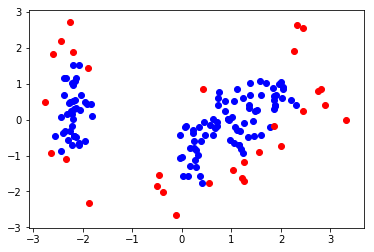

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(n):
    if us[i] >= alfa:
        plt.scatter(values[i][0],values[i][1],c='blue')
    else:
        plt.scatter(values[i][0],values[i][1],c='red')